# Naive Risk Budgeting Strategies between PSP and GHP

We've already seen how we can compute the returns of a portfolio that mixes a PSP with a GHP. In this session we'll build some tools to put a more methodical structure around that process.

In [2]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

We write the backtester
```python
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix
```

## 1. The Simplest Allocator - Fixed Mix

The allocator's job is to come up with a time series of weights, so let's create the simplest possible allocator - one that puts a fixed fraction in the first portfolio and the remaining in the second


```python
def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)
```

We are now ready to rerun the experiment we ran last time ... a bond portfolio of 60% in the 10 year bond and 40% in the 30 year bond to generate a fixed mix bond portfolio.

In [4]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0 = 0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)

rets_bonds = erk.bt_mix(rets_10, rets_30, allocator=erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.0358,0.003791,0.203405,3.053688,-0.001209,-0.00085,1.489088,0.0


In [17]:
rets_10

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,-0.017115,-0.027868,-0.021891,-0.019239,0.00878,-0.013156,0.016911,0.006942,0.014803,-0.008169,...,0.033348,0.031922,-0.044235,-0.025717,0.040513,0.006953,0.006135,-0.007535,0.01686,0.005899
2,0.031172,-0.003949,-0.019168,-0.008224,0.029262,-0.02252,-0.015173,-0.026553,0.017372,0.037527,...,-0.006705,0.006601,-0.044251,-0.017538,-0.031553,0.018514,0.036049,0.009643,0.014724,-0.022394
3,-0.008938,0.00936,0.00235,0.020754,-0.015144,0.020717,0.006091,-0.009575,0.022989,0.044669,...,-0.008801,-0.013782,-0.020595,-0.026018,-0.011422,-0.015392,0.012034,0.003959,0.021112,0.034688
4,0.022559,0.018607,-0.010378,-0.014936,0.043238,-0.014695,0.017798,0.015614,0.025812,0.018288,...,-0.007294,-0.004001,0.011015,0.014272,-0.005557,-0.009959,0.023897,0.04836,0.006719,0.008221
5,0.017408,0.018389,-0.007143,0.026199,0.006609,-0.00401,-0.005726,0.008192,0.012049,-0.025634,...,0.008264,-0.015864,-0.013518,0.016069,0.002936,-0.009891,0.001381,0.017806,0.011078,-0.024214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.004413,0.000345,0.000099,0.001136,0.000343,0.005291,-0.000113,0.001161,0.002938,0.000024,...,0.000613,0.001443,0.009695,0.001104,0.004741,0.001992,0.001326,0.001631,0.00008,-0.000138
117,0.005543,0.000004,0.000401,0.001421,0.002257,0.003189,-0.000037,0.001046,0.002957,0.000817,...,0.000242,0.002114,0.009695,0.001824,0.004523,0.003508,0.00313,0.001166,-0.000051,0.000619
118,0.004023,0.000154,0.000311,0.000836,0.0021,0.004264,0.000416,0.000988,0.002337,0.000818,...,0.000488,0.002402,0.009493,0.001254,0.003107,0.003011,0.001349,0.001183,0.000663,0.00092
119,0.003957,0.000032,0.000433,0.000755,0.001429,0.003218,0.00055,0.001058,0.002208,0.00094,...,0.000525,0.001549,0.009219,0.00178,0.002628,0.002763,0.001076,0.000762,0.000656,0.000559


In [5]:
rets_bonds

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
1,-0.026363,-0.041923,-0.033297,-0.029451,0.011874,-0.020588,0.024109,0.009124,0.020926,-0.013277,...,0.049182,0.046988,-0.065254,-0.038825,0.060253,0.00914,0.007918,-0.012345,0.024031,0.007565
2,0.045528,-0.007124,-0.029259,-0.013378,0.043171,-0.034171,-0.023682,-0.040204,0.02505,0.055516,...,-0.011165,0.008856,-0.064457,-0.026878,-0.047862,0.026677,0.053606,0.013108,0.021043,-0.034163
3,-0.014522,0.012466,0.002049,0.029573,-0.023804,0.029383,0.007861,-0.0154,0.034008,0.067902,...,-0.014335,-0.02178,-0.030766,-0.03894,-0.018184,-0.024113,0.017255,0.004667,0.031095,0.051017
4,0.032914,0.026446,-0.016571,-0.023348,0.065587,-0.022951,0.025674,0.021849,0.038917,0.027411,...,-0.012129,-0.0072,0.014165,0.019348,-0.009548,-0.01608,0.035888,0.073147,0.009213,0.011204
5,0.025398,0.02643,-0.011895,0.038037,0.009154,-0.007318,-0.009825,0.01089,0.017782,-0.040025,...,0.011213,-0.02493,-0.020845,0.0222,0.003051,-0.016012,0.001161,0.026414,0.016023,-0.037287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.00505,0.004448,-0.003625,0.003114,-0.019778,0.028308,-0.007189,0.001662,0.0106,-0.011772,...,0.001925,-0.003945,0.012482,-0.006106,0.025937,-0.009954,-0.003624,0.01093,-0.006213,-0.01234
117,0.030098,-0.001348,0.001316,0.011468,0.010879,-0.002752,-0.010008,-0.000759,0.016369,-0.000668,...,-0.006254,0.008159,0.014427,0.005993,0.03623,0.015926,0.037197,0.005811,-0.013432,-0.002304
118,0.005883,0.002833,-0.001076,0.000333,0.014163,0.026519,-0.003703,-0.004606,0.008394,-0.002118,...,-0.0039,0.024944,0.014552,-0.009611,0.019297,0.011691,0.006113,0.011203,-0.001437,0.00566
119,0.005534,-0.000695,0.00501,-0.00635,-0.008194,0.002608,-0.002412,-0.010836,0.011872,0.000653,...,-0.009944,0.009609,0.012045,0.004276,0.019517,0.012629,-0.003573,0.001045,-0.006083,-0.010475


Next, we'll use this to create a 70-30 Stock Bond Mix. First, we'll generate stock returns:

In [7]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stats on each scenario and average the summary stats.

And next, we'll use the mix backtester to build a 70-30 Stock-Bond mix. One way to assess the performance is, as before, to generate a composite and produce summary stats on the composite. We'll also examine a second approach, which is to compute summary stat on each scenario and average the summary stats.

In [8]:
rets_7030b = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis='columns')
erk.summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.061748,0.004867,-0.018562,2.766353,-0.002691,-0.002088,6.349464,0.0


In [11]:
rets_7030b_mean

1      0.005210
2      0.004183
3      0.005034
4      0.007185
5      0.001630
         ...   
116    0.003838
117    0.005630
118    0.005501
119    0.004822
120    0.005345
Length: 120, dtype: float64

In [9]:
# Approach 2: compute stats on each scenario and then average
summaries = erk.summary_stats(rets_7030b)
summaries.mean()

Annualized Return          0.056215
Annualized Vol             0.108112
Skewness                  -0.000688
Kurtosis                   2.939218
Cornish-Fisher VaR (5%)    0.046123
Historic CVaR (5%)         0.058341
Sharpe Ratio               0.237174
Max Drawdown              -0.205700
dtype: float64

In [12]:
summaries

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.058971,0.124736,0.230163,2.956556,0.051208,0.063506,0.225901,-0.161683
1,0.050763,0.115182,0.087491,3.242461,0.048793,0.061400,0.175309,-0.200959
2,0.123948,0.094610,0.469751,3.436568,0.030603,0.040613,0.966437,-0.091570
3,-0.000730,0.110168,0.619657,3.606751,0.045463,0.054587,-0.271598,-0.236203
4,0.047897,0.112166,-0.060714,2.693209,0.049366,0.060358,0.155154,-0.177331
...,...,...,...,...,...,...,...,...
495,0.110375,0.098065,-0.321438,3.531308,0.039429,0.056173,0.797641,-0.123627
496,0.017473,0.101729,0.183692,2.973957,0.044702,0.052682,-0.119968,-0.293464
497,0.029334,0.107070,0.298038,2.817100,0.045200,0.053104,-0.006182,-0.174300
498,0.012912,0.115913,0.003121,2.511242,0.053483,0.061905,-0.143620,-0.269533


However, both of these summaries are imperfect, since they aggregate across a wide distribution. In different situations one or the other might make sense, but for most individuals, the range of outcomes are what matters because we observe only one of the different possible scenarios.

Therefore, it make sense to example the range of possible outcomes and look at not just the average but also the less likely but possible outcomes.

## 2. Distribution of Terminal Values and Measuring Risk Budget Efficiency

The basic idea is to measure the distribution of terminal values across all scenarios.

```python
def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

```

In [13]:
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30")],
          axis=1)

,FI,Eq,70/30
mean,1.382349,2.039473,1.820706
std,0.116006,1.048292,0.634280
p_breach,NaN,0.052000,0.012000
e_short,NaN,0.114735,0.055187
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. P

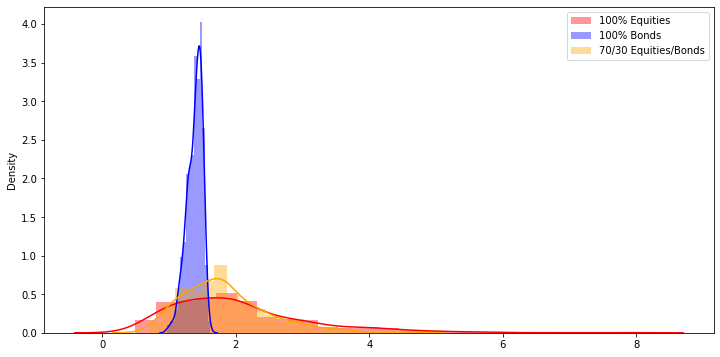

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(erk.terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

Note how the higher mean return of the equities portfolio is due in part to the large upside spread in equities.

##  2. Risk Budgeting through Glide Path Allocation

A potential improvement over naive fixed mix is to risk budget by making a simplistic assumption that risk = time.

In other words, if you have more time, increase the risk budget. If you have less time, derisk. This is the thinking behind a Target Date Fund.

Let's write an allocator that defines the weights as a glidepathsthat starts at a starting weight and then gradually decreases the weights to equities over time to an ending weight. For example, you can start at 80% stocks at the start of the 10 year period and then gradually move to 20% stocks by the end of the 10 year period.

Let's see how this does:

```python
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths
```

In [18]:
rets_g8020 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.8, end_glide=.2)
pd.concat([erk.terminal_stats(rets_bonds, name="FI"), 
           erk.terminal_stats(rets_eq, name="Eq"),
           erk.terminal_stats(rets_7030b, name="70/30"),
           erk.terminal_stats(rets_g8020, name="Glide 80 to 20")],
          axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.382349,2.039473,1.820706,1.694200
std,0.116006,1.048292,0.634280,0.443843
p_breach,NaN,0.052000,0.012000,NaN
e_short,NaN,0.114735,0.055187,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


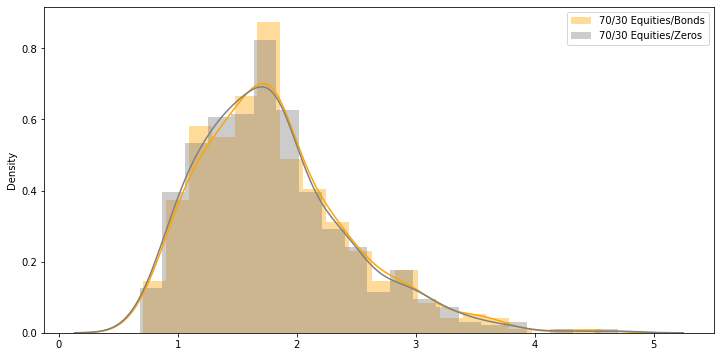

In [19]:
rets_7030z = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
plt.figure(figsize=(12, 6))
#sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
#sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(erk.terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
#sns.distplot(terminal_values(rets_g8020), color="green", label="Glide 80 to 20")
sns.distplot(erk.terminal_values(rets_7030z), color="grey", label="70/30 Equities/Zeros")
plt.legend();

### Conclusion

Static or Naive risk budgeting involves allocating between the PSP and GHP using either a simple fixed mix or a blind glidepath. These can reduce the downside risk but come at the cost the expected return, and cannot be used to secure a minimum acceptable level of wealth or liabilities. In the next session, we'll examine dynamic approaches that will address the challenge of meeting a set of future liabilities such as replacement income, or a required level of wealth in the future.

Before that, add the following code to the risk kit:

```python
def bt_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between a two sets of returns
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in the GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    """
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 should have the same shape")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights with a different shape than the returns")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix


def fixedmix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
     each column is a scenario
     each row is the price for a timestep
    Returns an T x N DataFrame of PSP Weights
    """
    return pd.DataFrame(data = w1, index=r1.index, columns=r1.columns)

def terminal_values(rets):
    """
    Computes the terminal values from a set of returns supplied as a T x N DataFrame
    Return a Series of length N indexed by the columns of rets
    """
    return (rets+1).prod()

def terminal_stats(rets, floor = 0.8, cap=np.inf, name="Stats"):
    """
    Produce Summary Statistics on the terminal values per invested dollar
    across a range of N scenarios
    rets is a T x N DataFrame of returns, where T is the time-step (we assume rets is sorted by time)
    Returns a 1 column DataFrame of Summary Stats indexed by the stat name 
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std" : terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short":e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats

def glidepath_allocator(r1, r2, start_glide=1, end_glide=0.0):
    """
    Allocates weights to r1 starting at start_glide and ends at end_glide
    by gradually moving from start_glide to end_glide over time
    """
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

```
